In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from decimal import Decimal
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
t_beg=time.time()
man_450='data/array/man_450.csv'

gse_dic={
      'GSE152027':{'label':'Preiph. blood (n=384)','cats':[10,20,30,40,50,70]},
      'GSE40279' :{'label':'Periph. blood (n=656)','cats':[20,30,40,50,60,70,80,100]},
      'GSE42861' :{'label':'Periph. blood leuk. (n=689)','cats':[20,30,40,50,60,70,80,100]},
      'GSE55763' :{'label':'Periph. blood (n=2711)','cats':[20,30,40,50,60,70,80,100]},
}
gses=list(gse_dic.keys())
dic={
    'lm':'Low meth.',
    'ez':'PRC2 targets',
    'eze':'Low exp. PRC2 targets'
}
def cal(man,gses,n):
    pls=[]
    for gse in gses:
        print (gse)
        t=time.time()
        df=pd.read_csv('data/array/'+gse+'.csv',index_col=0,nrows=10**n)
        age=pd.read_csv('data/array/'+gse+'a.csv',index_col=0)
        print(time.time()-t)
        print(df.shape)
        df=df.T
        df=df.merge(age,left_index=True,right_index=True)
        df.loc[:,'lm']=df[df.columns.intersection(man[(man.n<.5)].index)].mean(1)
        df.loc[:,'ez']=df[df.columns.intersection(man[(man.hz)].index)].mean(1)        
        df.loc[:,'eze']=df[df.columns.intersection(man[(man.hz)&(man.e<1)].index)].mean(1)        
        fs=['lm','ez','eze']
        pl=df[['age']+fs]
        cats=gse_dic[gse]['cats']
        pl['agec']=pd.cut(pl['age'],cats,labels=np.array(cats[:-1])+[5])
        pls.append(pl)
        pl.to_csv('results/'+gse+'.csv') 
    return pls

In [41]:
man=pd.read_csv(man_450,index_col=0)
h=pd.read_csv('data/h.csv',index_col=0)
hz=h[h.ezg=='High'].copy()
hz['r']=hz.apply(lambda x:set(range(x['b'],x['e'])),axis=1)
hzg=hz.groupby('ch')['r'].apply(list)
hzg=hzg.apply(lambda x:set.union(*x))
man['hz']=man.apply(lambda x:int(str(x['g'])[-9:]) in hzg['chr'+str(x['CHR'])],axis=1)
man.hz.value_counts()

False    387501
True      20338
Name: hz, dtype: int64

In [67]:
n=6
pls=cal(man,gses,6)

GSE152027
34.089147090911865
(483756, 800)


/local/scratch/moqri/slrmtmp.30908517/ipykernel_60181/112667018.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl['agec']=pd.cut(pl['age'],cats,labels=np.array(cats[:-1])+[5])


GSE40279
22.97264051437378
(473034, 656)
GSE42861
25.445011138916016
(485578, 689)
GSE55763
176.0523874759674
(473864, 2711)


In [3]:
tabs={}
for gs in gses:
    tab=pd.read_csv('results/'+str(gs)+'.csv',index_col=0)
    agec=tab['agec']
    tab=tab.drop(['agec'],axis=1)-(tab[tab['agec']==25].mean())
    tab['agec']=agec
    tab['Dataset']=gs 
    tabs[gs]=tab
tabs=pd.concat(tabs.values())
#tabs=tabs.dropna()      

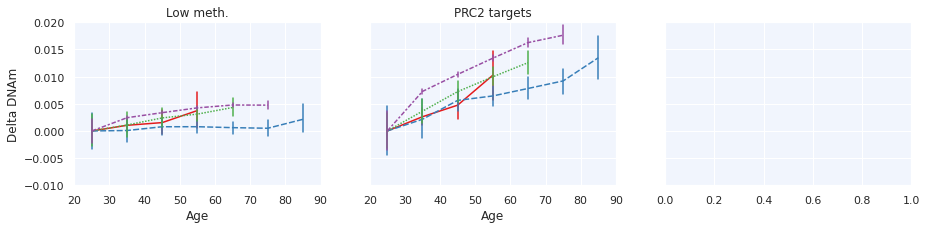

In [5]:
pl=tabs[tabs['agec']>20]#.dropna()
i=0
sns.set_context("paper")
sns.set(rc={'axes.facecolor':'#f1f5fd'})
fig, (a1, a2, a3, ) = plt.subplots(ncols=3, sharey=True,figsize=(15,3));
a={1:a1,2:a2,3:a3,}
for y in ['lm','ez']:
    i+=1
    ln=-.01;lp=.02
    ax=sns.lineplot(data=pl,x='agec',y=y,hue='Dataset',style='Dataset',err_style="bars",legend=False,ax=a[i],
                    palette='Set1')                
    ax.set_xlabel('Age')#,fontsize=10);
    ax.set_ylabel('Delta DNAm')#,fontsize=10);
    ax.set_title(dic[y]);#,fontsize=12);
    ax.set(ylim=(ln, lp),xlim=(20, 90))